In [208]:
using ITensors
using Random
using Plots
using QuadGK
using Roots
using StatsBase

In [209]:
function get_probability_density(x::Float64, rdm::Matrix)
    """Takes in the 1-site reduced density matrix and 
    returns the probability of a given time series value, x 
    (note, x is before applying encoding, NOT ϕ(x))."""
    # convert time series value to encoded state by applying feature map
    # our complex feature map
    state = [exp(1im * (3π/2) * x) * cospi(0.5 * x), exp(-1im * (3π/2) * x) * sinpi(0.5 * x)]
    return abs(state' * rdm * state) # |<x|ρ|x>|
end

function get_normalisation_constant(rdm::Matrix)
    """Get the normalisation constant Z for the pdf"""
    prob_density_wrapper(x) = get_probability_density(x, rdm)
    norm_const, _ = quadgk(prob_density_wrapper, 0, 1) # integrate over data/x domain
    return norm_const
end

function get_cdf(x::Float64, rdm::Matrix, integral_norm_const::Float64)
    """Get the cumulative distribution function via numerical integration of
    the probability density function.

        Returns cdf evaluated at x where x is the proposed value i.e., F(x)."""

    prob_density_wrapper(x_prime) = (1/integral_norm_const) * get_probability_density(x_prime, rdm)

    cdf_val, _ = quadgk(prob_density_wrapper, 0, x) # pdf has support on the interval [0, 1] so integrate accordingly
    
    return cdf_val
end

function sample_state_from_rdm(rdm)
    """Given a 1 site RDM, samples a random value according to the
    conditional distribution encapsulated by the rdm using inverse transform sampling.
    Returns both the sampled value x (the un-feature mapped value) and the feature mapped
    value ϕ(x)."""
    norm_factor = get_normalisation_constant(rdm)
    u = rand() # sample a uniform random value from ~U(0,1)
    # solve for x by defining an auxilary function g(x) such that g(x) = F(x) - u and then use root finder to solve for x such that g(x) = 0
    cdf_wrapper(x) = get_cdf(x, rdm, norm_factor) - u
    sampled_x = find_zero(cdf_wrapper, (0, 1); rtol=0)
    # map sampled value back to a state
    sampled_state = [exp(1im * (3π/2) * sampled_x) * cospi(0.5 * sampled_x), exp(-1im * (3π/2) * sampled_x) * sinpi(0.5 * sampled_x)]
    
    return sampled_x, sampled_state

end

sample_state_from_rdm (generic function with 1 method)

# Shrinking MPS approach

6 site MPS, condition at sites 3, 5 - interpolate the rest. Resulting mps after conditioning should be 4 sites long and consist of the original sites 1,2,4,6

In [210]:
s = siteinds("S=1/2", 6)
mps = randomMPS(ComplexF64, s; linkdims=4);

Start by measuring at site 3

In [211]:
orthogonalize!(mps, 3)

MPS
[1] ((dim=2|id=733|"S=1/2,Site,n=1"), (dim=2|id=618|"Link,l=1"))
[2] ((dim=2|id=555|"S=1/2,Site,n=2"), (dim=2|id=618|"Link,l=1"), (dim=4|id=361|"Link,l=2"))
[3] ((dim=2|id=95|"S=1/2,Site,n=3"), (dim=4|id=242|"Link,l=3"), (dim=4|id=361|"Link,l=2"))
[4] ((dim=4|id=242|"Link,l=3"), (dim=2|id=122|"S=1/2,Site,n=4"), (dim=4|id=903|"Link,l=4"))
[5] ((dim=4|id=903|"Link,l=4"), (dim=2|id=567|"S=1/2,Site,n=5"), (dim=2|id=222|"Link,l=5"))
[6] ((dim=2|id=222|"Link,l=5"), (dim=2|id=680|"S=1/2,Site,n=6"))


In [212]:
A = mps[3];
rdm = prime(A, s[3]) * dag(A)
rdm_m = matrix(rdm);
known_x = 0.3
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[3]);
Am = A * dag(known_state_as_ITensor)
# absorb into right site
A_new = mps[4] * Am

ITensor ord=3 (dim=2|id=122|"S=1/2,Site,n=4") (dim=4|id=903|"Link,l=4") (dim=4|id=361|"Link,l=2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [213]:
proba_state = get_probability_density(known_x, rdm_m)
A_new *= 1/sqrt(proba_state);

In [214]:
norm(A_new)

0.9999999999999997

Store new mps. Contains all sites from original MPS except measurement site and it's right neighbour (which is now updated).

In [215]:
current_site = 3
prev = 1:current_site-1
next = (current_site+2):length(mps)

5:6

In [216]:
new_mps = MPS(vcat(mps[prev], A_new, mps[next]))

MPS
[1] ((dim=2|id=733|"S=1/2,Site,n=1"), (dim=2|id=618|"Link,l=1"))
[2] ((dim=2|id=555|"S=1/2,Site,n=2"), (dim=2|id=618|"Link,l=1"), (dim=4|id=361|"Link,l=2"))
[3] ((dim=2|id=122|"S=1/2,Site,n=4"), (dim=4|id=903|"Link,l=4"), (dim=4|id=361|"Link,l=2"))
[4] ((dim=4|id=903|"Link,l=4"), (dim=2|id=567|"S=1/2,Site,n=5"), (dim=2|id=222|"Link,l=5"))
[5] ((dim=2|id=222|"Link,l=5"), (dim=2|id=680|"S=1/2,Site,n=6"))


In [217]:
norm(new_mps)

0.9999999999999993

Now measure site 5

In [219]:
site_5_loc = findsite(new_mps, s[5])

4

In [221]:
orthogonalize!(new_mps, site_5_loc)

MPS
[1] ((dim=2|id=733|"S=1/2,Site,n=1"), (dim=2|id=811|"Link,l=1"))
[2] ((dim=2|id=555|"S=1/2,Site,n=2"), (dim=2|id=811|"Link,l=1"), (dim=4|id=866|"Link,l=2"))
[3] ((dim=2|id=122|"S=1/2,Site,n=4"), (dim=4|id=866|"Link,l=2"), (dim=4|id=319|"Link,l=4"))
[4] ((dim=2|id=567|"S=1/2,Site,n=5"), (dim=4|id=319|"Link,l=4"), (dim=2|id=926|"Link,l=5"))
[5] ((dim=2|id=680|"S=1/2,Site,n=6"), (dim=2|id=926|"Link,l=5"))


In [222]:
A = new_mps[site_5_loc]

ITensor ord=3 (dim=2|id=567|"S=1/2,Site,n=5") (dim=4|id=319|"Link,l=4") (dim=2|id=926|"Link,l=5")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [223]:
rdm = prime(A, s[5]) * dag(A)
rdm_m = matrix(rdm);
known_x = 0.9
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[5]);
Am = A * dag(known_state_as_ITensor)
# absorb into right site
A_new = new_mps[(site_5_loc+1)] * Am

ITensor ord=2 (dim=2|id=680|"S=1/2,Site,n=6") (dim=4|id=319|"Link,l=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [224]:
proba_state = get_probability_density(known_x, rdm_m)
A_new *= 1/sqrt(proba_state);

In [225]:
norm(A_new)

1.0

In [228]:
new_mps

MPS
[1] ((dim=2|id=733|"S=1/2,Site,n=1"), (dim=2|id=811|"Link,l=1"))
[2] ((dim=2|id=555|"S=1/2,Site,n=2"), (dim=2|id=811|"Link,l=1"), (dim=4|id=866|"Link,l=2"))
[3] ((dim=2|id=122|"S=1/2,Site,n=4"), (dim=4|id=866|"Link,l=2"), (dim=4|id=319|"Link,l=4"))
[4] ((dim=2|id=567|"S=1/2,Site,n=5"), (dim=4|id=319|"Link,l=4"), (dim=2|id=926|"Link,l=5"))
[5] ((dim=2|id=680|"S=1/2,Site,n=6"), (dim=2|id=926|"Link,l=5"))


Store new mps

In [233]:
current_site = site_5_loc
prev = 1:current_site-1
next = (current_site+2):length(new_mps)

6:5

In [235]:
new_mps2 = MPS(vcat(new_mps[prev], A_new))

MPS
[1] ((dim=2|id=733|"S=1/2,Site,n=1"), (dim=2|id=811|"Link,l=1"))
[2] ((dim=2|id=555|"S=1/2,Site,n=2"), (dim=2|id=811|"Link,l=1"), (dim=4|id=866|"Link,l=2"))
[3] ((dim=2|id=122|"S=1/2,Site,n=4"), (dim=4|id=866|"Link,l=2"), (dim=4|id=319|"Link,l=4"))
[4] ((dim=2|id=680|"S=1/2,Site,n=6"), (dim=4|id=319|"Link,l=4"))


In [236]:
norm(new_mps2)

0.9999999999999998

### Trial 2

Measure sites 1, 3, 5 in a 6 site mps -> remaining mps should be original sites 2, 4, 6

In [237]:
s = siteinds("S=1/2", 6)
mps = randomMPS(ComplexF64, s; linkdims=4);

In [239]:
orthogonalize!(mps, 1);

In [240]:
A = mps[1];
rdm = prime(A, s[1]) * dag(A)
rdm_m = matrix(rdm);
known_x = 0.4866
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[1]);
Am = A * dag(known_state_as_ITensor)
# absorb into right site
A_new = mps[2] * Am

ITensor ord=2 (dim=2|id=546|"S=1/2,Site,n=2") (dim=4|id=352|"Link,l=2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [241]:
proba_state = get_probability_density(known_x, rdm_m)
A_new *= 1/sqrt(proba_state);

In [242]:
norm(A_new)

0.9999999999999997

If current site = 1, then no prev, and if current site = length of current mps, then no next

In [243]:
current_site = 1
next = (current_site+2):length(mps)

3:6

In [244]:
new_mps = MPS(vcat(A_new, mps[next]))

MPS
[1] ((dim=2|id=546|"S=1/2,Site,n=2"), (dim=4|id=352|"Link,l=2"))
[2] ((dim=4|id=352|"Link,l=2"), (dim=2|id=200|"S=1/2,Site,n=3"), (dim=4|id=341|"Link,l=3"))
[3] ((dim=4|id=341|"Link,l=3"), (dim=2|id=61|"S=1/2,Site,n=4"), (dim=4|id=823|"Link,l=4"))
[4] ((dim=4|id=823|"Link,l=4"), (dim=2|id=275|"S=1/2,Site,n=5"), (dim=2|id=92|"Link,l=5"))
[5] ((dim=2|id=92|"Link,l=5"), (dim=2|id=605|"S=1/2,Site,n=6"))


In [245]:
norm(new_mps)

0.9999999999999997

now measure site 3...

In [246]:
site_3_loc = findsite(new_mps, s[3])

2

In [249]:
orthogonalize!(new_mps, site_3_loc);

In [252]:
A = new_mps[site_3_loc];
rdm = prime(A, s[3]) * dag(A)
rdm_m = matrix(rdm);
known_x = 0.95
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[3]);
Am = A * dag(known_state_as_ITensor)
# absorb into right site
A_new = new_mps[site_3_loc+1] * Am

ITensor ord=3 (dim=2|id=61|"S=1/2,Site,n=4") (dim=4|id=780|"Link,l=4") (dim=2|id=865|"Link,l=2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [253]:
proba_state = get_probability_density(known_x, rdm_m)
A_new *= 1/sqrt(proba_state);

In [254]:
norm(A_new)

1.0

In [255]:
current_site = site_3_loc
prev = 1:current_site-1
next = (current_site+2):length(new_mps)

4:5

In [258]:
new_mps2 = MPS(vcat(new_mps[prev], A_new, new_mps[next]))

MPS
[1] ((dim=2|id=546|"S=1/2,Site,n=2"), (dim=2|id=865|"Link,l=2"))
[2] ((dim=2|id=61|"S=1/2,Site,n=4"), (dim=4|id=780|"Link,l=4"), (dim=2|id=865|"Link,l=2"))
[3] ((dim=2|id=275|"S=1/2,Site,n=5"), (dim=2|id=862|"Link,l=5"), (dim=4|id=780|"Link,l=4"))
[4] ((dim=2|id=605|"S=1/2,Site,n=6"), (dim=2|id=862|"Link,l=5"))


In [259]:
norm(new_mps2)

1.0

Now measure site 5

In [261]:
site_5_loc = findsite(new_mps2, s[5])

3

In [262]:
orthogonalize!(new_mps2, site_5_loc);

In [263]:
A = new_mps2[site_5_loc];
rdm = prime(A, s[5]) * dag(A)
rdm_m = matrix(rdm);
known_x = 0.7
known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
known_state_as_ITensor = ITensor(known_state, s[5]);
Am = A * dag(known_state_as_ITensor)
# absorb into right site
A_new = new_mps2[site_5_loc+1] * Am

ITensor ord=2 (dim=2|id=605|"S=1/2,Site,n=6") (dim=4|id=118|"Link,l=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [264]:
proba_state = get_probability_density(known_x, rdm_m)
A_new *= 1/sqrt(proba_state);

In [265]:
norm(A_new)

1.0000000000000004

In [269]:
current_site = site_5_loc
prev = 1:current_site-1
next = (current_site+2):length(new_mps2)

5:4

In [270]:
new_mps3 = MPS(vcat(new_mps2[prev], A_new))

MPS
[1] ((dim=2|id=546|"S=1/2,Site,n=2"), (dim=2|id=673|"Link,l=2"))
[2] ((dim=2|id=61|"S=1/2,Site,n=4"), (dim=2|id=673|"Link,l=2"), (dim=4|id=118|"Link,l=4"))
[3] ((dim=2|id=605|"S=1/2,Site,n=6"), (dim=4|id=118|"Link,l=4"))


In [271]:
norm(new_mps3)

1.0000000000000002

In [415]:
s = siteinds("S=1/2", 100)
mps = randomMPS(ComplexF64, s; linkdims=4);
ts = rand(100);

In [423]:
function interpolate_acausal(label_mps::MPS, time_series::Vector{Float64},
    interpolate_sites::Vector{Int})

    mps = deepcopy(label_mps)
    s = siteinds(mps)
    known_sites = setdiff(collect(1:length(mps)), interpolate_sites)
    x_samps = Vector{Float64}(undef, length(mps))
    original_mps_length = length(mps)

    # condition the mps on known values
    for i in 1:original_mps_length
        if i in known_sites
            #println("Conditioning MPS at site n = $i using known value")
            site_loc = findsite(mps, s[i]) # use original site indices
            #println("Site Loc: $site_loc")
            known_x = time_series[i]
            x_samps[i] = known_x
            orthogonalize!(mps, site_loc)
            A = mps[site_loc]
            # get the rdm
            rdm = prime(A, s[i]) * dag(A)
            rdm_m = matrix(rdm) # convert to matrix
            known_state = [exp(1im * (3π/2) * known_x) * cospi(0.5 * known_x), exp(-1im * (3π/2) * known_x) * sinpi(0.5 * known_x)]
            known_state_as_ITensor = ITensor(known_state, s[i]);
            # make measurement by contracting with the site
            Am = A * dag(known_state_as_ITensor)
            # absorb into next site if it exists
            if site_loc != length(mps)

                A_new = mps[(site_loc+1)] * Am
            else
                # absorb into previous site
                A_new = mps[(site_loc-1)] * Am
            end
            # normalise by the probability
            proba_state = get_probability_density(known_x, rdm_m)
            A_new *= 1/sqrt(proba_state);
            # check the norm
            if !isapprox(norm(A_new), 1.0)
                error("Site not normalised")
            end

            # make a new mps
            current_site = site_loc

            if current_site == 1
                next = (current_site+2):length(mps)
                new_mps = MPS(vcat(A_new, mps[next]))
            elseif current_site == length(mps)
                prev = 1:(current_site-2)
                new_mps = MPS(vcat(mps[prev], A_new))
            else
                prev = 1:current_site-1
                next = (current_site+2):length(mps)
                new_mps = MPS(vcat(mps[prev], A_new, mps[next]))
            end

            mps = new_mps
            #println(mps)

        end

    end

    # now sample from the interpolation sites
    # check the normalisation of the mps
    if !isapprox(norm(mps), 1.0)
        error("MPS is not normalised after conditioning: $(norm(mps))")
    end

    # place the mps into right canonical form
    #samples = []
    orthogonalize!(mps, 1)
    s = siteinds(mps)
    A = mps[1]
    count = 1
    for i in eachindex(mps)
        rdm = prime(A, s[i]) * dag(A)
        rdm_m = matrix(rdm)
        sampled_x, sampled_state = sample_state_from_rdm(rdm_m)
        # use the site index to determine the location to save to
        x_samps[interpolate_sites[count]] = sampled_x
        #push!(samples, sampled_x)
        if i != length(mps)
            sampled_state_as_ITensor = ITensor(sampled_state, s[i])
            proba_state = get_probability_density(sampled_x, rdm_m)
            Am = A * dag(sampled_state_as_ITensor)
            A_new = mps[(i+1)] * Am
            A_new *= 1/sqrt(proba_state)
            A = A_new
        end
        count += 1
    end

    return x_samps
    
end


interpolate_acausal (generic function with 1 method)

In [434]:
out = interpolate_acausal(mps, ts, [1, 2, 3]);
out

100-element Vector{Float64}:
 0.4356037774499279
 0.9475631985540723
 0.46821957597587543
 0.3694785918560186
 0.0992452216171611
 0.43979010722301326
 0.3189901254944145
 0.14201105537088243
 0.2790174754620762
 0.7853199402776373
 ⋮
 0.502483963385861
 0.6523215937559151
 0.0604228471968582
 0.9339363322653922
 0.017088994818340364
 0.7929774714539313
 0.34869381234206975
 0.2224496867895035
 0.1975398770783755

In [440]:
outs_all = Matrix{Float64}(undef, 100, 100)
for i in 1:100
    outs_all[i, :] = interpolate_acausal(mps, ts, collect(30:1:50));
end

In [442]:
mean_ts = mean(outs_all, dims=1)[1, :]
std_ts = std(outs_all, dims=1)[1,:];

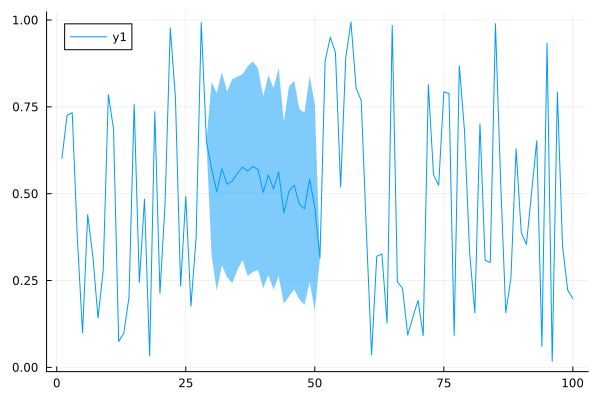

In [443]:
plot(mean_ts, ribbon=std_ts)